In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

resultsPath = Path("../results/OpenMP_1.csv")


In [13]:
dataFrame = pd.read_csv(resultsPath)

dataFrame["problemSize"] = dataFrame["problemSize"].astype(int)
dataFrame["numThreads"] = dataFrame["numThreads"].astype(int)
dataFrame["timeSeconds"] = dataFrame["timeSeconds"].astype(float)
dataFrame["runIndex"] = dataFrame["runIndex"].astype(int)

print("Loaded rows:", len(dataFrame))
print("Modes:", dataFrame["mode"].unique())
print("Problem sizes:", sorted(dataFrame["problemSize"].unique()))
print("Thread counts:", sorted(dataFrame["numThreads"].unique()))
dataFrame.head(8)


Loaded rows: 300
Modes: ['reduction' 'no_reduction']
Problem sizes: [1000000, 5000000, 10000000, 50000000, 100000000]
Thread counts: [1, 2, 4, 8, 16, 32]


,testType,problemSize,numThreads,mode,timeSeconds,minValue,runIndex,ompEnv
0,OpenMP_1,1000000,1,reduction,0.000164,338,1,OMP_NUM_THREADS=1
1,OpenMP_1,1000000,1,reduction,0.000163,158,2,OMP_NUM_THREADS=1
2,OpenMP_1,1000000,1,reduction,0.000163,94,3,OMP_NUM_THREADS=1
3,OpenMP_1,1000000,1,reduction,0.000170,1244,4,OMP_NUM_THREADS=1
4,OpenMP_1,1000000,1,reduction,0.000172,424,5,OMP_NUM_THREADS=1
5,OpenMP_1,1000000,2,reduction,0.000206,135,1,OMP_NUM_THREADS=2
6,OpenMP_1,1000000,2,reduction,0.000190,72,2,OMP_NUM_THREADS=2
7,OpenMP_1,1000000,2,reduction,0.000198,527,3,OMP_NUM_THREADS=2


In [14]:
groupedFrame = dataFrame.groupby(["mode","problemSize","numThreads"], as_index=False).agg(
    median=("timeSeconds","median"),
    mean=("timeSeconds","mean"),
    std=("timeSeconds","std"),
    count=("timeSeconds","count")
)

groupedFrame["std"] = groupedFrame["std"].fillna(0.0)
groupedFrame = groupedFrame.sort_values(["mode","problemSize","numThreads"]).reset_index(drop=True)
groupedFrame.head(12)

,mode,problemSize,numThreads,median,mean,std,count
0,no_reduction,1000000,1,0.000165,0.000166,0.000003,5
1,no_reduction,1000000,2,0.000244,0.000245,0.000034,5
2,no_reduction,1000000,4,0.000301,0.000288,0.000034,5
3,no_reduction,1000000,8,0.000389,0.000403,0.000047,5
4,no_reduction,1000000,16,0.000596,0.000601,0.000025,5
5,no_reduction,1000000,32,0.001081,0.001062,0.000073,5
6,no_reduction,5000000,1,0.000807,0.000803,0.000013,5
7,no_reduction,5000000,2,0.000604,0.000607,0.000005,5
8,no_reduction,5000000,4,0.000565,0.000559,0.000019,5
9,no_reduction,5000000,8,0.000639,0.000673,0.000055,5


In [15]:
def computeSpeedupEfficiency(groupedDf):
    frames = []
    for (modeVal, problemSizeVal), subFrame in groupedDf.groupby(["mode","problemSize"]):
        baseRows = subFrame[subFrame["numThreads"] == 1]
        if baseRows.empty:
            continue
        baseTime = float(baseRows["median"].values[0])
        subFrame = subFrame.copy()
        subFrame["speedup"] = baseTime / subFrame["median"]
        subFrame["efficiency"] = subFrame["speedup"] / subFrame["numThreads"]
        frames.append(subFrame)
    return pd.concat(frames, ignore_index=True)

perfFrame = computeSpeedupEfficiency(groupedFrame)
perfFrame.head(12)


,mode,problemSize,numThreads,median,mean,std,count,speedup,efficiency
0,no_reduction,1000000,1,0.000165,0.000166,0.000003,5,1.000000,1.000000
1,no_reduction,1000000,2,0.000244,0.000245,0.000034,5,0.678571,0.339286
2,no_reduction,1000000,4,0.000301,0.000288,0.000034,5,0.548987,0.137247
3,no_reduction,1000000,8,0.000389,0.000403,0.000047,5,0.425373,0.053172
4,no_reduction,1000000,16,0.000596,0.000601,0.000025,5,0.277489,0.017343
5,no_reduction,1000000,32,0.001081,0.001062,0.000073,5,0.152956,0.004780
6,no_reduction,5000000,1,0.000807,0.000803,0.000013,5,1.000000,1.000000
7,no_reduction,5000000,2,0.000604,0.000607,0.000005,5,1.335981,0.667991
8,no_reduction,5000000,4,0.000565,0.000559,0.000019,5,1.429938,0.357484
9,no_reduction,5000000,8,0.000639,0.000673,0.000055,5,1.263026,0.157878


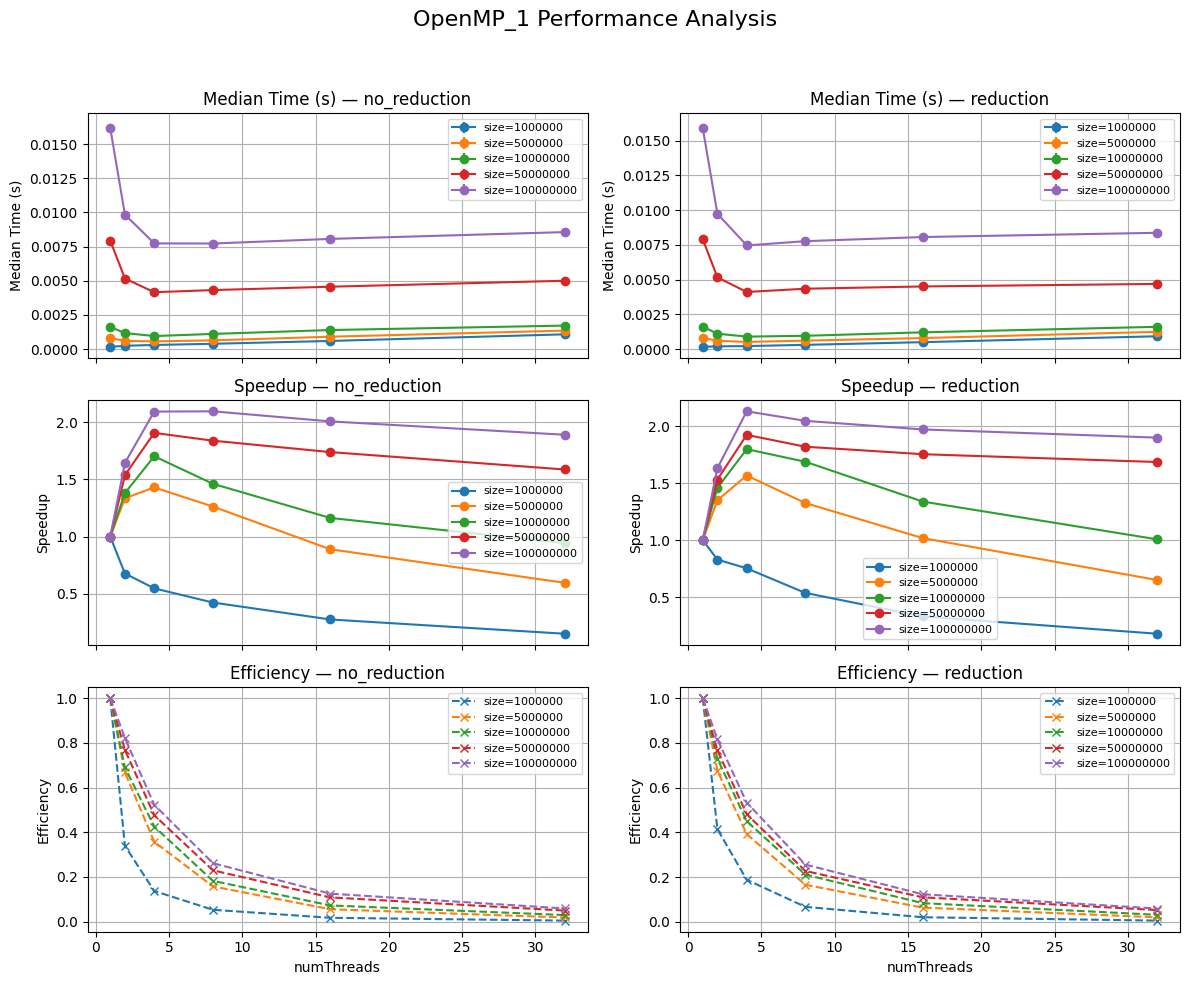

In [16]:
modes = sorted(perfFrame["mode"].unique())
metrics = ["median", "speedup", "efficiency"]
metricLabels = {
    "median": "Median Time (s)",
    "speedup": "Speedup",
    "efficiency": "Efficiency"
}

fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True)
axes = axes.flatten()

for colIdx, modeVal in enumerate(modes):
    for rowIdx, metric in enumerate(metrics):
        axIdx = rowIdx*2 + colIdx
        ax = axes[axIdx]
        
        for problemSizeVal in sorted(perfFrame["problemSize"].unique()):
            subFrame = perfFrame[(perfFrame["mode"]==modeVal) & (perfFrame["problemSize"]==problemSizeVal)].sort_values("numThreads")
            if subFrame.empty:
                continue
            x = subFrame["numThreads"].values
            y = subFrame[metric].values
            if metric == "median":
                yerr = subFrame["std"].values
                ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=f"size={problemSizeVal}")
            else:
                markerStyle = 'o' if metric == "speedup" else 'x'
                linestyle = '-' if metric == "speedup" else '--'
                ax.plot(x, y, marker=markerStyle, linestyle=linestyle, label=f"size={problemSizeVal}")

        ax.set_title(f"{metricLabels[metric]} — {modeVal}")
        if rowIdx == 2:
            ax.set_xlabel("numThreads")
        ax.set_ylabel(metricLabels[metric])
        ax.grid(True)
        ax.legend(fontsize=8)

plt.suptitle("OpenMP_1 Performance Analysis", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [17]:
for modeVal in perfFrame["mode"].unique():
    pivotTime = perfFrame[perfFrame["mode"]==modeVal].pivot(index="numThreads", columns="problemSize", values="median")
    pivotSpeedup = perfFrame[perfFrame["mode"]==modeVal].pivot(index="numThreads", columns="problemSize", values="speedup")
    print(f"\n=== mode: {modeVal} — median time (s) ===")
    display(pivotTime)
    print(f"\n=== mode: {modeVal} — speedup ===")
    display(pivotSpeedup)



=== mode: no_reduction — median time (s) ===


problemSize,1000000,5000000,10000000,50000000,100000000
numThreads,,,,,
1,0.000165,0.000807,0.001622,0.007935,0.016178
2,0.000244,0.000604,0.001175,0.005163,0.009841
4,0.000301,0.000565,0.000953,0.004163,0.007733
8,0.000389,0.000639,0.001110,0.004317,0.007725
16,0.000596,0.000906,0.001393,0.004564,0.008063
32,0.001081,0.001351,0.001719,0.005001,0.008561



=== mode: no_reduction — speedup ===


problemSize,1000000,5000000,10000000,50000000,100000000
numThreads,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.678571,1.335981,1.380255,1.536839,1.643855
4,0.548987,1.429938,1.702141,1.906051,2.091992
8,0.425373,1.263026,1.461608,1.838013,2.094294
16,0.277489,0.890556,1.163832,1.738465,2.006449
32,0.152956,0.597351,0.943565,1.586591,1.889733



=== mode: reduction — median time (s) ===


problemSize,1000000,5000000,10000000,50000000,100000000
numThreads,,,,,
1,0.000164,0.000809,0.001616,0.007912,0.015909
2,0.000198,0.000598,0.001108,0.005164,0.009744
4,0.000218,0.000516,0.000898,0.004112,0.007465
8,0.000306,0.000610,0.000957,0.004347,0.007770
16,0.000498,0.000795,0.001207,0.004510,0.008068
32,0.000924,0.001245,0.001605,0.004694,0.008373



=== mode: reduction — speedup ===


problemSize,1000000,5000000,10000000,50000000,100000000
numThreads,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.828701,1.351270,1.458837,1.532254,1.632711
4,0.751949,1.567054,1.798664,1.924336,2.131157
8,0.535948,1.325574,1.688009,1.820129,2.047582
16,0.329251,1.017619,1.338496,1.754502,1.971877
32,0.177489,0.649426,1.006602,1.685721,1.900004


In [18]:
summaryRows = []
for (modeVal, problemSizeVal), sub in perfFrame.groupby(["mode","problemSize"]):
    maxSpeedup = sub["speedup"].max()
    argMax = sub.loc[sub["speedup"].idxmax()]
    bestThreads = int(argMax["numThreads"])
    effAtBest = float(argMax["efficiency"])
    medianAtOne = sub.loc[sub["numThreads"]==1, "median"]
    medianAtOne = float(medianAtOne.values[0]) if not medianAtOne.empty else np.nan
    summaryRows.append({
        "mode": modeVal,
        "problemSize": problemSizeVal,
        "bestNumThreads": bestThreads,
        "maxSpeedup": maxSpeedup,
        "efficiencyAtBest": effAtBest,
        "medianTime1Thread": medianAtOne
    })

summaryAnalysisFrame = pd.DataFrame(summaryRows).sort_values(["mode","problemSize"])
display(summaryAnalysisFrame)


,mode,problemSize,bestNumThreads,maxSpeedup,efficiencyAtBest,medianTime1Thread
0,no_reduction,1000000,1,1.000000,1.000000,0.000165
1,no_reduction,5000000,4,1.429938,0.357484,0.000807
2,no_reduction,10000000,4,1.702141,0.425535,0.001622
3,no_reduction,50000000,4,1.906051,0.476513,0.007935
4,no_reduction,100000000,8,2.094294,0.261787,0.016178
5,reduction,1000000,1,1.000000,1.000000,0.000164
6,reduction,5000000,4,1.567054,0.391764,0.000809
7,reduction,10000000,4,1.798664,0.449666,0.001616
8,reduction,50000000,4,1.924336,0.481084,0.007912
9,reduction,100000000,4,2.131157,0.532789,0.015909
